In [1]:
import os
from glob import glob
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt     # for plotting
import cv2 
import soundfile as sf

import librosa
import pandas as pd
from IPython.display import Audio
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from collections import Counter

from tensorflow.keras.layers import LSTM, Dense

In [2]:
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

Global Variables

In [3]:
# Data path:
data_path = '../data/'
speakers_path = '../SPEAKERS.TXT'

sample_rate = 32000
off_set = 0
duration = 5.0

# If you decide to use batch sizes:
batch_size = 10000

sample_size = (round((sample_rate*duration)), 1)

#Mel features
hop_length = 512 #the default spacing between frames, try 512?
n_fft = 1024 #number of samples
n_mels = 64



Helper Functions

In [4]:
def extract_id_sex():
    id_sex_array = []
    with open(speakers_path, 'r') as file:
        # Skip the header line
        next(file)
        for line in file:
            # Split the line into columns
            columns = line.split('|')
            # Extract the ID and SEX
            id_value = columns[0].strip()
            sex_value = columns[1].strip()
            # Append ID and SEX to the array
            id_sex_array.append((id_value, sex_value))
    return id_sex_array

# Lets store the speaker gender, it'll only be used once.
speaker_gender = extract_id_sex()

def load_directory():
    # Find all samples in the directory
    files = glob(os.path.join(data_path, '*.flac'))
    # The audio data
    x = []
    # The gender and speaker ID
    y = []

    # Create a dictionary for speaker genders
    speaker_gender_dict = {speaker[0]: speaker[1] for speaker in speaker_gender}

    counter_f = 0
    counter_m = 0
    speakers = []

    if batch_size > len(files):
        error_msg = f'Requested a batch size greater than the number of samples available ({len(files)})'
        raise ValueError(error_msg)

    for file in files:
        if (len(x) == batch_size):
            break
        
        # Collect the speaker IDs, because we are classifying on gender the speakerID does not 
        # matter as a label, but it does help us ensure we have a diverse representation of 
        # speakers for each gender, so we will only take 1 sample per speaker for each gender.
        fileName = file.split('\\')[1]
        speakerId = fileName.split('-')[0]

        # Due to limited number of samples per speaker limit the below code to 14500
        if batch_size < 14500:
            # extract an even number of samples from each speaker ensuring we get a diverse
            # range of speakers 
            num_samples_per_speaker = round(batch_size / 250)
            speaker_count = Counter(speakers)
            if (speaker_count[speakerId] >= num_samples_per_speaker):
                continue
        
        # Use dictionary for faster search performance.
        gender = speaker_gender_dict.get(speakerId)

        if (gender == 'F' and (counter_f < batch_size/2)):
            data, _ = librosa.load(file, sr=sample_rate, offset=off_set, duration=duration)
            
            if (data.size < (sample_rate*duration)):
                continue
            x.append(data)
            y.append((gender, speakerId))
            speakers.append(speakerId)
            counter_f = counter_f + 1

        elif (gender == 'M' and (counter_m < batch_size/2)):
            data, _ = librosa.load(file, sr=sample_rate, offset=off_set, duration=duration)
            if (data.size < (sample_rate*duration)):
                continue
            x.append(data)
            y.append((gender, speakerId))
            speakers.append(speakerId)
            counter_m = counter_m + 1
    x = [get_mels(x_data, sample_rate, hop_length, n_fft, n_mels).T  for x_data in x]
    return np.array(x), np.array(y)

In [5]:
#Helper Functions

def get_mels(x, sample_rate, hop_length=512, n_fft=1024, n_mels=64):
    
    S = librosa.feature.melspectrogram(y =x, sr = sample_rate, hop_length=hop_length,n_fft = n_fft, n_mels=n_mels)
    S_db_mel = librosa.power_to_db(S, ref=np.max)
    return S_db_mel


# Convert iterable into batches of size n
#   iterable: original list of data to be batched
#   n: batch size 

#   yields:   a list of batches with each batch of size n
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

# Get y label and a unique ID for each file and load the file into a tuple
#   file: directory to the file

#   returns:   a tuple containing the audio file, speaker ID and a unique ID for the file name
def get_metadata(file):
    basename = os.path.basename(file)
    data, samp_rate = librosa.load(file, sr=sample_rate)
    speakerId = basename.split('-')[0]
    uniqueId = basename.split('.')[0]
    return (data, uniqueId), speakerId


def load_data(base_path):
    # get list of all flac files in the base directory
    files = glob(os.path.join(base_path, '*.flac'))
    features=[]
    ds = list(map(get_metadata, files))
    x_data = [x for x,y in ds]
    y_data = [y for x,y in ds]
    y_data = pd.factorize(y_data)[0]

    x_data = [get_mels(x, sample_rate, hop_length, n_fft, n_mels).T  for x in x_data]

    # for file, unique_id in x_data: 
    #     data = np.array([librosa.feature.mfcc(y=file, sr=sample_rate, n_fft=n_fft,hop_length=hop_length,n_mfcc=128).transpose()])
    #     features.append(data)
    # output=np.concatenate(features,axis=0)

    #output = get_sequences(output, 10)

    #return(np.array(output), y_data)
    return x_data, y_data


In [6]:
#extract_sequences(X_train, 20, 20, 5, 128)

Load Data

In [7]:
x_data, y = load_directory()
# Information on the extracted audio data:
print(f'x data, first sample: {x_data[0]}')
print(f'shape x data: {x_data.shape}')

y_data = np.array([row[0] for row in y])
speakerIds = [row[1] for row in y]
print(f'shape y data: {y_data.shape}')

m_rows = y[y[:, 0] == 'M']
f_rows = y[y[:, 0] == 'F']
print()
print(f'Male Speakers: {len(np.unique(m_rows[:, 1]))}')
print(f'Female Speakers: {len(np.unique(f_rows[:, 1]))}')

x data, first sample: [[-27.368961 -29.47931  -36.750004 ... -75.74742  -75.96059  -76.09476 ]
 [-22.879776 -30.233055 -49.52315  ... -80.       -80.       -80.      ]
 [-21.997183 -28.55328  -47.38311  ... -80.       -80.       -80.      ]
 ...
 [-26.280758 -35.079685 -44.866646 ... -80.       -80.       -80.      ]
 [-17.730782 -24.628962 -51.294506 ... -80.       -80.       -80.      ]
 [-16.015625 -21.281998 -37.17293  ... -80.       -80.       -80.      ]]
shape x data: (10000, 313, 64)
shape y data: (10000,)

Male Speakers: 126
Female Speakers: 125


In [8]:
# X = np.array((X-np.min(X))/(np.max(X)-np.min(X)))
# X = X/np.std(X)
# y = np.array(y)

In [9]:
x_train, x_remain, y_train, y_remain = train_test_split(x_data, y_data, 
                                                        test_size=0.6, 
                                                        random_state=42, 
                                                        shuffle=True,
                                                        stratify=y_data)





x_val, x_test, y_val, y_test = train_test_split(x_remain, y_remain, 
                                                test_size=0.5, 
                                                random_state=42, 
                                                shuffle=True,
                                                stratify=y_remain)


In [11]:
from sklearn.preprocessing import LabelEncoder
# Convert 'M' (1) and 'F' (0) to numbers. 
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)
print(y_train[0])
print(y_train_encoded[0])
print(y_train[90])
print(y_train_encoded[90])

M
1
F
0


In [12]:
input_shape=(313, n_mels)
model = keras.Sequential()
model.add(LSTM(70,input_shape=input_shape, name='LSTM_1'))
#model.add(Dense(64, activation='relu'))
#model.add(layers.Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, 70)                37800     
                                                                 
 dense (Dense)               (None, 32)                2272      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 40,617
Trainable params: 40,617
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer='adam',loss='BinaryCrossentropy',metrics=['acc'])

In [14]:

import time
start = time.time()
history = model.fit(x_train, y_train_encoded, epochs=100, batch_size=100, 
                    validation_data=(x_val, y_val_encoded), shuffle=False, verbose=True)

end = time.time()
model_training = end - start

Epoch 1/100
70/70 [==============================] - 24s 323ms/step - loss: 0.6664 - acc: 0.5946 - val_loss: 0.6496 - val_acc: 0.6073
Epoch 2/100
70/70 [==============================] - 26s 373ms/step - loss: 0.6279 - acc: 0.6621 - val_loss: 0.5719 - val_acc: 0.7727
Epoch 3/100
70/70 [==============================] - 26s 374ms/step - loss: 0.5365 - acc: 0.7533 - val_loss: 0.5693 - val_acc: 0.7367
Epoch 4/100
70/70 [==============================] - 26s 365ms/step - loss: 0.5553 - acc: 0.7470 - val_loss: 0.4758 - val_acc: 0.8093
Epoch 5/100
70/70 [==============================] - 26s 374ms/step - loss: 0.4701 - acc: 0.8126 - val_loss: 0.4859 - val_acc: 0.7887
Epoch 6/100
70/70 [==============================] - 26s 376ms/step - loss: 0.4534 - acc: 0.8201 - val_loss: 0.4393 - val_acc: 0.8053
Epoch 7/100
70/70 [==============================] - 26s 378ms/step - loss: 0.4207 - acc: 0.8336 - val_loss: 0.3799 - val_acc: 0.8533
Epoch 8/100
70/70 [==============================] - 25s 359ms

In [15]:
model_training

2676.1257288455963

In [16]:
model_training/60

44.602095480759935

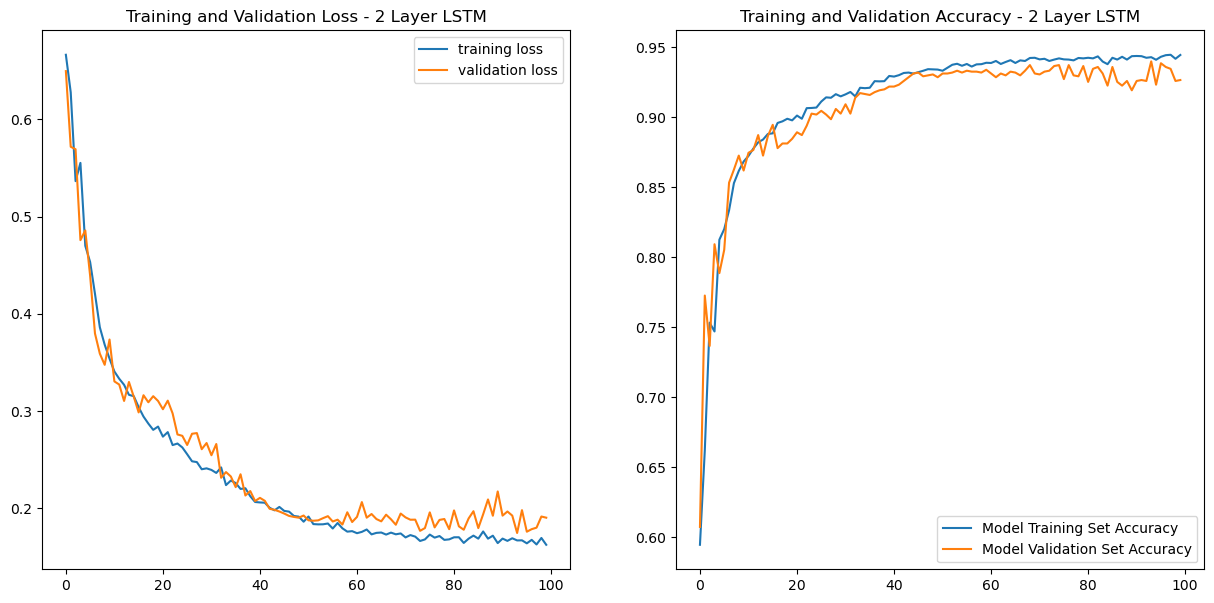

In [17]:
fig = plt.figure(figsize=[15, 7])
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label='training loss')
ax.plot(history.history['val_loss'], label='validation loss')
ax.set_title('Training and Validation Loss - 2 Layer LSTM')
ax.legend()
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['acc'], label='Model Training Set Accuracy')
ax.plot(history.history['val_acc'], label='Model Validation Set Accuracy')
ax.set_title('Training and Validation Accuracy - 2 Layer LSTM')
ax.legend()
plt.savefig('../out/LSTM_model_loss_2_layer.png')

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
import time

pred_lab = model.predict(x_train);
train_indexes = np.round(pred_lab)

pred_lab = model.predict(x_val);
val_indexes = np.round(pred_lab)
start = time.time()
pred_lab = model.predict(x_test);
test_indexes = np.round(pred_lab)

f1_train = f1_score(y_train_encoded, train_indexes)
f1_val = f1_score(y_val_encoded, val_indexes)
f1_test = f1_score(y_test_encoded, test_indexes)

acc_train = accuracy_score(y_train_encoded, train_indexes)
acc_val = accuracy_score(y_val_encoded, val_indexes)
acc_test = accuracy_score(y_test_encoded, test_indexes)
end = time.time()
model_inference = end - start

In [19]:
acc_test

0.946

In [20]:
model_inference 

1.648056983947754

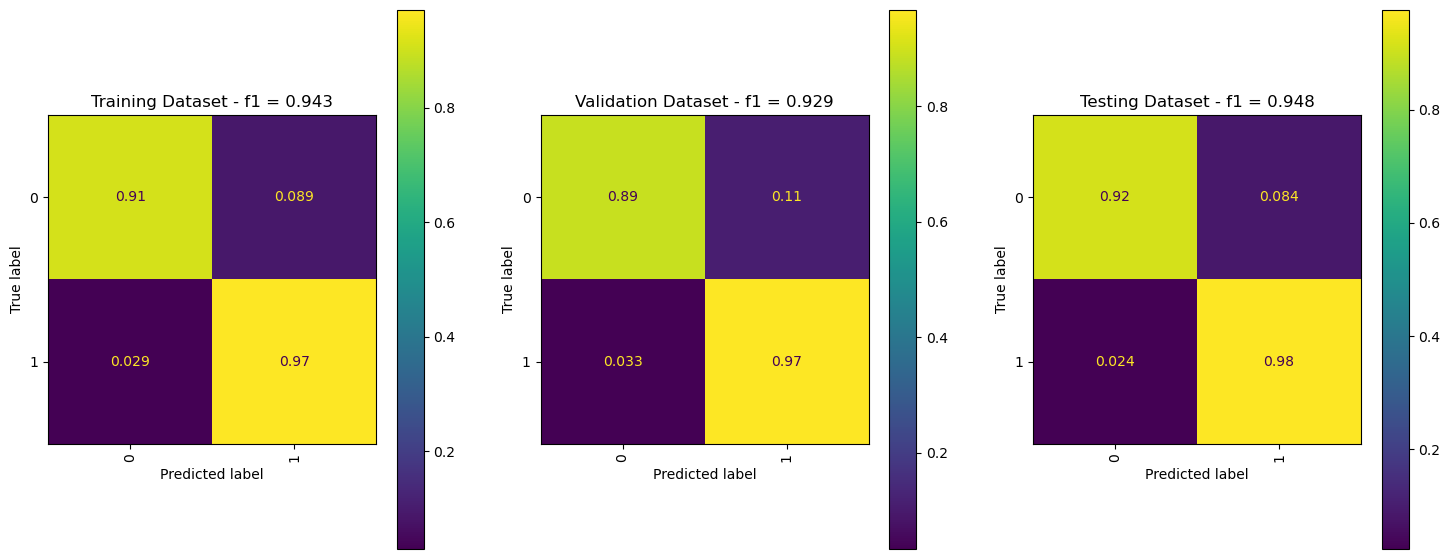

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
fig = plt.figure(figsize=[18, 7])


ax = fig.add_subplot(1, 3, 1)
ax.set_title(f"Training Dataset - f1 = {round(f1_train, 3)}")
cm = confusion_matrix(y_train_encoded, train_indexes, normalize='true')
c = ConfusionMatrixDisplay(cm)
c.plot(ax = ax, xticks_rotation = 'vertical')

ax = fig.add_subplot(1, 3, 2)
ax.set_title(f"Validation Dataset - f1 = {round(f1_val, 3)}")
cm = confusion_matrix(y_val_encoded, val_indexes, normalize='true')
c = ConfusionMatrixDisplay(cm)
c.plot(ax = ax, xticks_rotation = 'vertical')

ax = fig.add_subplot(1, 3, 3)
ax.set_title(f"Testing Dataset - f1 = {round(f1_test,3)}")
cm = confusion_matrix(y_test_encoded, test_indexes, normalize='true')
c = ConfusionMatrixDisplay(cm)
c.plot(ax = ax,  xticks_rotation = 'vertical')

plt.savefig('../out/LSTM_2_layer_Confusion_Matrix.jpg')

In [ ]:
import pickle
pickle.dump(history, open('../out/LSTM_2_layer_history.pkl', 'wb'))
pickle.dump(model, open('../out/LSTM_2_layer_Model_speaker.pkl', 'wb'))

c:\Users\mpato\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\mpato\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


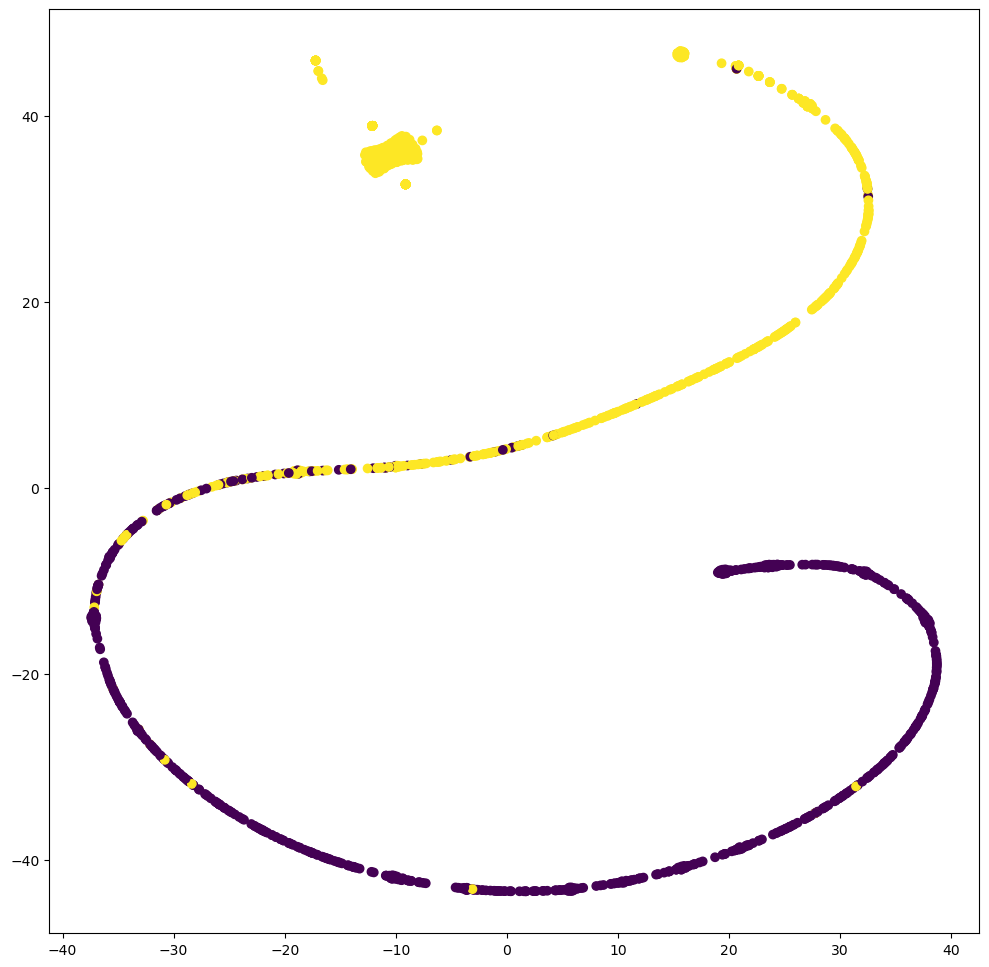

In [22]:
from sklearn.manifold import TSNE

test_embeddings = model.predict(x_test)
tsne_embeddings = TSNE(random_state=4).fit_transform(test_embeddings)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = y_test_encoded.flatten());
plt.savefig('../out/LSTM_2_layer_clusters.jpg')

In [ ]:
# model = pickle.load(open('../out/LSTM_2_layer_Model_speaker.pkl', 'rb'))
# with open('../out/LSTM_2_layer_history.pkl', "rb") as file_pi:
#     history = pickle.load(file_pi)